## Exercise Intructions:

The goal of this challenge is to train a model that can identify whether a work of art was created by Pablo Picasso or Vincent van Gogh. The dataset provided has a total of 2,000 images. Half of the images were created by Picasso and the other half were created by van Gogh.

The two main goals of this project are to:

1. Create a model and train it OR finetune a pre-trained model
2. Optimize a hyperparameter for the network that you've chosen to use -- Please show the experiments that you used to perform this optimization

Your submission should include:
- A description of what you did
- Why you made the design choices you made
- Analysis and explanation of model performance
- A Jupyter notebook is preferred, but raw code with an accompanying document describing your methods is fine.

In [1]:
# First import some basic packages
import os
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt

# Set randomization seeds constant across training conditions
#  this is important for reproducible results and testing influence of different hyperparameters later
from numpy.random import seed
import tensorflow as tf
from tensorflow import set_random_seed
import random as rn
from keras import backend as K

seed(1)
set_random_seed(2)
rn.seed(3)


Using TensorFlow backend.


## First do some preprocessing to load the dataset and prepare for the input to our neural networks

In [2]:
#  First go through the artist folders and rename to something consistent across files and artists

artist_dir = '/home/arthur/Data/Artists/'

vg_filenames = os.listdir(artist_dir + '/vanGogh')
p_filenames = os.listdir(artist_dir + '/Picasso')

print(str(len(vg_filenames)) + ' Files For VanGogh')
print(str(len(p_filenames)) + ' Files For Picasso')

# Rename the files in each folder
# for ind, filename in enumerate(vg_filenames): 
#     file_pre = artist_dir + '/vanGogh/'
#     os.rename(file_pre + filename, file_pre + 'vg_' + str(ind).zfill(4) + '.jpg')

# for ind, filename in enumerate(p_filenames): 
#     file_pre = artist_dir + '/Picasso/'
#     os.rename(file_pre + filename, file_pre + 'p_' + str(ind).zfill(4) + '.jpg')


866 Files For VanGogh
1125 Files For Picasso



___

So we don't have even numbers of images for both artists - I want to make sure I use even numbers of samples for the training dataset, but not as concerned about the test set. 

Lets start with 500 images for each class for training (1000 total), 200 for validation set (400 total), and the remaining images will be used for the test set
___

In [3]:
# We are going to use an image generator during training so we copy the images 
# in to training, validation, and test folders to be able to pass them to the model for training

vg_filenames = os.listdir(artist_dir + 'vanGogh/')
p_filenames = os.listdir(artist_dir + 'Picasso/')

vg_filenames.sort()
p_filenames.sort()

vg_train_files = vg_filenames[:500]
vg_val_files = vg_filenames[500:700]
vg_test_files = vg_filenames[700:len(vg_filenames)]

p_train_files = p_filenames[:500]
p_val_files = p_filenames[500:700]
p_test_files = p_filenames[700:len(p_filenames)]

# Copy images to respective directory
# for filename in vg_train_files:
#     vg_dst = artist_dir + 'train_data/vangogh/' + filename
#     vg_src = artist_dir + 'vanGogh/' + filename
#     copyfile(vg_src, vg_dst)
    
# for filename in vg_val_files:
#     vg_dst = artist_dir + 'val_data/vangogh/' + filename
#     vg_src = artist_dir + 'vanGogh/' + filename
#     copyfile(vg_src, vg_dst)
    
# for filename in vg_test_files:
#     vg_dst = artist_dir + 'test_data/vangogh/' + filename
#     vg_src = artist_dir + 'vanGogh/' + filename
#     copyfile(vg_src, vg_dst)
    
# for filename in p_train_files:
#     p_dst = artist_dir + 'train_data/picasso/' + filename
#     p_src = artist_dir + 'Picasso/' + filename
#     copyfile(p_src, p_dst)
    
# for filename in p_val_files:
#     p_dst = artist_dir + 'val_data/picasso/' + filename
#     p_src = artist_dir + 'Picasso/' + filename
#     copyfile(p_src, p_dst)
    
# for filename in p_test_files:
#     p_dst = artist_dir + 'test_data/picasso/' + filename
#     p_src = artist_dir + 'Picasso/' + filename
#     copyfile(p_src, p_dst)
    

# Now we can build our basic CNN to extract painting features and try to classify the images based on the artist

In [4]:
import keras
from keras import layers
from keras import models
from keras import optimizers

# 3x3 Conv and 2x2 MaxPool typically work well for CNN architectures (we can stack a few of these layers for our first CNN)
# 5x5 might also be a good one to try, but we could miss some granularity

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)             0         
__________

The CNN model contructed above is relatively simple, but has enough conv and maxpool layers that it should be able to extract features across multiple spatial scales. 

During model compilation we set the loss to 'binary_crossentropy' which is well suited for binary classification and we are using an optimizer called RMSprop which is an optimized gradient descent algorithm. Another good option for an adaptive optimizer is 'adam'. The learning rate of 2e-4 is a decent starting point but anywhere in a range of 1e-3 to 1e-5 might be good to try, but smaller learning rates can drastically increase training time...  

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# Create a generator for preprocessing the images on the fly during training 

# Rescale images to be from 0 -> 1 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = artist_dir + 'train_data/'
val_dir = artist_dir + 'val_data/'

# The generators also reshape the images to a constant 150x150 size for the model input
# 150x150 is a decent size for training quickly while still preserving some finer features of the paintings
# Keras uses PIL backend to resize/interpolate images
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


With the image generators we set a couple additional parameters for training the CNN. We are using a target size of 150x150 for the input images, meaning we will have to resize the paintings to fit the square shape. This can be problematic because it will induce streching or squishing of rectangular images to fit the square, though it is a decent method to start. An alternative would be maintaining the aspect ratios of the images and then padding (adding zeros) around the images to reach the desired input shape, but this zero-padding can be problematic for training.

We also set the class mode at this stage which tells the generator how to assign labels to our folders with images. Since we are just trying to decide between two artists we set the mode to binary. Lastly we set the batch size at this step - this is a balance between large batches that feed the most data in to the network but require increasing amounts of memory and small batches that only allow the model to see small parts of the data at a time and may take longer to train. 20 is an ok place to start, we could try going up to 30/40/50 if our GPU has enough memory, but the dataset is relatively small so training time at this stage isn't really an issue.   

In [6]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, # how many batches we process in a single epoch 
    epochs=20, # how many complete iterations over the dataset
    validation_data=val_generator, 
    validation_steps=50, 
    workers=12) # adding workers lets keras use multiple CPU threads which drastically speeds up image preprocessing 

Epoch 1/20
100/100 [==============================] - 11s 110ms/step - loss: 0.6531 - acc: 0.6545 - val_loss: 0.4991 - val_acc: 0.7550
Epoch 2/20
100/100 [==============================] - 8s 80ms/step - loss: 0.4827 - acc: 0.7685 - val_loss: 0.5481 - val_acc: 0.7200
Epoch 3/20
100/100 [==============================] - 8s 80ms/step - loss: 0.3796 - acc: 0.8340 - val_loss: 0.4854 - val_acc: 0.7730
Epoch 4/20
100/100 [==============================] - 8s 84ms/step - loss: 0.3047 - acc: 0.8715 - val_loss: 0.5113 - val_acc: 0.7400
Epoch 5/20
100/100 [==============================] - 8s 82ms/step - loss: 0.2305 - acc: 0.9190 - val_loss: 0.5497 - val_acc: 0.7500
Epoch 6/20
100/100 [==============================] - 8s 84ms/step - loss: 0.1621 - acc: 0.9415 - val_loss: 0.5320 - val_acc: 0.7770
Epoch 7/20
100/100 [==============================] - 8s 80ms/step - loss: 0.1092 - acc: 0.9635 - val_loss: 0.6228 - val_acc: 0.7970
Epoch 8/20
100/100 [==============================] - 8s 83ms/step 

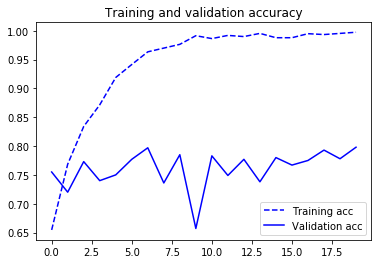

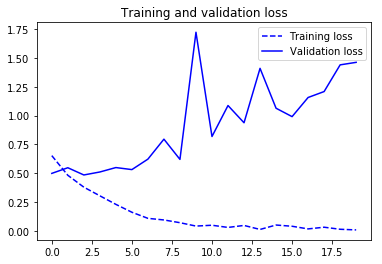

In [7]:
# Lets make a plotting function to be able to visualize our training curves for our different models

def plot_training(training_history):
    acc = training_history.history['acc']
    val_acc = training_history.history['val_acc']
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b--', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b--', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
plot_training(history)

In [8]:
# Save model 
model.save('Artists_v1.h5')

Found 591 images belonging to 2 classes.
Test Classification Results:
  Pred. VanGogh Correct  - 127
  Pred. Picasso Correct  - 337
  Pred. VanGogh Miss - 39
  Pred. Picasso Miss - 88

Test Accuracy: 0.7851099830795262
VanGogh Accuracy: 0.7650602409638554
Picasso Accuracy: 0.7929411764705883
F1 Score: 0.6666666666666666

Normalized confusion matrix


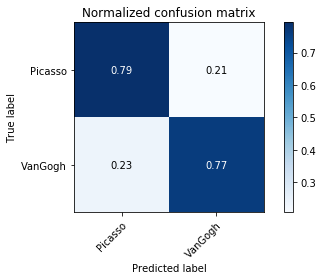

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Finally, how well do we classify on our test set?

# Confusion Matrix Plot (plotting code from SKlearn examples)
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Display performance metrics from (Also uses confusion matrix function from Sklearn)
def perf_eval(test_dir, model):
    
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(150, 150),
            batch_size=1,
            class_mode='binary')

    pred_label = []
    actual_label = []
    count = 591
    batch_size = 1

    i = 0
    for inputs_batch, labels_batch in test_generator:
        pred_label.append(round(model.predict(inputs_batch).tolist()[0][0]))
        actual_label.append(round(labels_batch.tolist()[0]))
        i += 1
        if i * batch_size >= count:
            break

    pc, pm, vgm, vgc = confusion_matrix(actual_label, pred_label).ravel()
    
    print('Test Classification Results:')
    print('  Pred. VanGogh Correct  - ' + str(vgc))
    print('  Pred. Picasso Correct  - ' + str(pc))
    print('  Pred. VanGogh Miss - ' + str(vgm))
    print('  Pred. Picasso Miss - ' + str(pm))

    print()
    
    total_accuracy = (vgc + pc) / len(pred_label)
    vg_accuracy = vgc / (vgc + vgm)
    p_accuracy = pc / (pc + pm)
    
    f1 = f1_score(actual_label, pred_label, labels=['Picasso','VanGogh'])
    
    print('Test Accuracy: ' + str(total_accuracy))
    print('VanGogh Accuracy: ' + str(vg_accuracy))
    print('Picasso Accuracy: ' + str(p_accuracy))
    print('F1 Score: ' + str(f1))
    print()
    
    plot_confusion_matrix(actual_label, pred_label, classes=['Picasso','VanGogh'])
    
    
test_dir = artist_dir + 'test_data/'
perf_eval(test_dir, model)

## So we have an initial model that can predict the artist with ~78% test accuracy

A further breakdown of the classification results above shows the model is slightly skewed as we are better classifying Picasso paintings (80%) compared to VanGogh (75%). Another useful classification metric is the F1 score, which is a weighted average of precision and recall (1 is the best, 0 the worst). We get an F1 score of 0.66 for the current classification results.

But we are starting to overfit pretty early in training (the validation accuracy plateaus and loss increases as the training accuracy approaches 1...). We see our best validation accuracy at only the second epoch

Perhaps the best way to improve the model and reduce overfitting is to get more data. Unfortunately we can't get any more paintings from the artists, but fortunately there are lots of other ways to regularize and improve our models accuracy - to name a few:

1. We could augment the incoming images to create similar, but different paintings to add to the training data. 

2. We can add dropout to one or a few of the layers

3. We could try to use a smaller CNN

4. We might use a pre-trained CNN architechture (VGG, ResNet, etc)

___

Lets first try training the same NN architecture with __image augmentation__ to see if we can get test accuracy above 78%

Image augmentation artificially provides more training data by manipulating the training images in a variety of ways like rotating, stretching, zooming, or flipping the images.


In [10]:
# only augment the training dataset
train_datagen_wAug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, # this will rotate the image within a range of 40deg
    width_shift_range=0.2, # the next two will stretch/compress the images
    height_shift_range=0.2,
    shear_range=0.2, # will shear the image
    zoom_range=0.2, # zoom in on image
    horizontal_flip=True,) # can flip the image along the horizontal axis

# Validation set remains the same
val_datagen = ImageDataGenerator(rescale=1./255) 

train_dir = artist_dir + 'train_data/'
val_dir = artist_dir + 'val_data/'

train_generator_wAug = train_datagen_wAug.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [11]:
# Create another model (model_wAug) and see how data augmentation helps with overfitting and test accuracy

model_wAug = models.Sequential()
model_wAug.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_wAug.add(layers.MaxPooling2D((2, 2)))
model_wAug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_wAug.add(layers.MaxPooling2D((2, 2)))
model_wAug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_wAug.add(layers.MaxPooling2D((2, 2)))
model_wAug.add(layers.Flatten())
model_wAug.add(layers.Dense(512, activation='relu'))
model_wAug.add(layers.Dense(1, activation='sigmoid'))

model_wAug.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['acc'])

# Let this model train a bit longer since it shouldn't overfit as quickly
history_wAug = model_wAug.fit_generator(
      train_generator_wAug,
      steps_per_epoch=100,
      epochs=30, # increased epochs from 20 to 30 for this model
      validation_data=val_generator,
      validation_steps=50,
      workers=12) # also added workers to reduce up CPU bottleneck 

Epoch 1/30
100/100 [==============================] - 10s 102ms/step - loss: 0.6662 - acc: 0.6295 - val_loss: 0.7766 - val_acc: 0.5760
Epoch 2/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5593 - acc: 0.7065 - val_loss: 0.5994 - val_acc: 0.7300
Epoch 3/30
100/100 [==============================] - 9s 91ms/step - loss: 0.5258 - acc: 0.7280 - val_loss: 0.5220 - val_acc: 0.7520
Epoch 4/30
100/100 [==============================] - 9s 85ms/step - loss: 0.5029 - acc: 0.7525 - val_loss: 0.5962 - val_acc: 0.7010
Epoch 5/30
100/100 [==============================] - 9s 91ms/step - loss: 0.4821 - acc: 0.7660 - val_loss: 0.4958 - val_acc: 0.7450
Epoch 6/30
100/100 [==============================] - 9s 90ms/step - loss: 0.4780 - acc: 0.7690 - val_loss: 0.6950 - val_acc: 0.7300
Epoch 7/30
100/100 [==============================] - 9s 93ms/step - loss: 0.4734 - acc: 0.7820 - val_loss: 0.4703 - val_acc: 0.7900
Epoch 8/30
100/100 [==============================] - 9s 89ms/step 

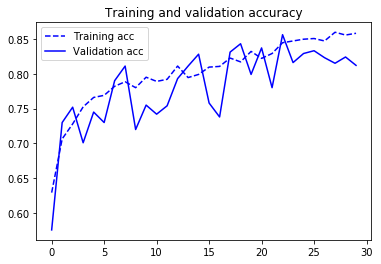

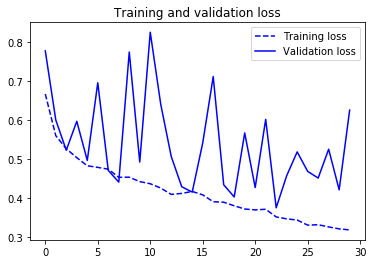

In [12]:
plot_training(history_wAug)

Looking at the training curves tell us a few things:
1. We are no longer over-fitting (well maybe slightly...)! training and validation accuracy now closely follow eachother across all epochs
2. We see peak validation accuracy and minimum loss around epoch 20. Could possibly end training earlier for best results
___

Lets check performance on the test set:

Found 591 images belonging to 2 classes.
Test Classification Results:
  Pred. VanGogh Correct  - 111
  Pred. Picasso Correct  - 398
  Pred. VanGogh Miss - 55
  Pred. Picasso Miss - 27

Test Accuracy: 0.8612521150592216
VanGogh Accuracy: 0.6686746987951807
Picasso Accuracy: 0.9364705882352942
F1 Score: 0.730263157894737

Normalized confusion matrix


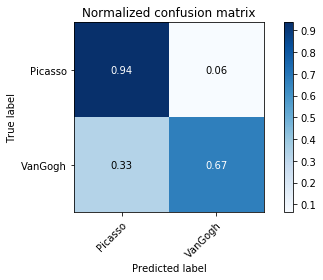

In [13]:
perf_eval(test_dir, model_wAug)

In [14]:
# Save model 
model_wAug.save('Artists_v1wAug.h5')

## Now Test Accuracy Increases to ~86% with image augmentation

Great! But this is a little misleading... with the confusion matrix we can see that the model does a great job classifying Picasso paintings, but now tends to incorrectly classify nearly 1/3 of VanGogh paitings as Picasso...

Perhaps some hyperparameter adjustments can improve these shortcomings.

## Hyperparameter Tuning

A couple hyperparameters that can have significant results in model training and performance include:
- learning rate
- hidden layers
- batch size

Lets give hidden layers a try - testing its impact by training multiple models with varying numbers of layers


In [15]:
# Hidden Layer Testing - Try using different numbers of hidden layers to improve performance

# Function to return CNN model with number of hidden layers based on num_layers input
def HL_Depth_Test(num_layers):
    model_HL_Test = models.Sequential()
    model_HL_Test.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model_HL_Test.add(layers.MaxPooling2D((2, 2)))
    model_HL_Test.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model_HL_Test.add(layers.MaxPooling2D((2, 2)))
    # Lets preserve early layers and adjust how many final layers are included
    for i in range(num_layers):
        model_HL_Test.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model_HL_Test.add(layers.MaxPooling2D((2, 2)))
    
    model_HL_Test.add(layers.Flatten())
    model_HL_Test.add(layers.Dense(512, activation='relu'))
    model_HL_Test.add(layers.Dense(1, activation='sigmoid'))

    model_HL_Test.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=2e-4),
                  metrics=['acc'])
    
    return model_HL_Test


In [16]:
# Check to make sure function is working 
model_HL1 = HL_Depth_Test(2)
model_HL1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [17]:
# Try using between 0 and 2 final hidden layers (1 is the same as the original model)

n_layers = [0, 1, 2]

history_results = []
model_results = []

for add_layers in n_layers:
    print(str(add_layers) + ' : training condition')
    temp_model = HL_Depth_Test(add_layers)
    temp_history = temp_model.fit_generator(
        train_generator_wAug,
        steps_per_epoch=100,
        epochs=30,
        validation_data=val_generator,
        validation_steps=50,
        workers=12)
    history_results.append(temp_history)
    model_results.append(temp_model)
    
    # save each model
    temp_model.save('Artists_HLtest_' + str(add_layers) + '.h5')
    

0 : training condition
Epoch 1/30
100/100 [==============================] - 11s 110ms/step - loss: 0.7757 - acc: 0.6160 - val_loss: 0.5278 - val_acc: 0.7270
Epoch 2/30
100/100 [==============================] - 9s 92ms/step - loss: 0.5418 - acc: 0.7140 - val_loss: 0.4797 - val_acc: 0.7750
Epoch 3/30
100/100 [==============================] - 9s 91ms/step - loss: 0.4991 - acc: 0.7455 - val_loss: 0.4703 - val_acc: 0.7730
Epoch 4/30
100/100 [==============================] - 9s 93ms/step - loss: 0.4805 - acc: 0.7620 - val_loss: 0.5798 - val_acc: 0.7480
Epoch 5/30
100/100 [==============================] - 9s 91ms/step - loss: 0.4814 - acc: 0.7590 - val_loss: 0.4689 - val_acc: 0.7980
Epoch 6/30
100/100 [==============================] - 9s 93ms/step - loss: 0.4570 - acc: 0.7780 - val_loss: 0.5527 - val_acc: 0.7500
Epoch 7/30
100/100 [==============================] - 9s 92ms/step - loss: 0.4480 - acc: 0.7800 - val_loss: 0.4808 - val_acc: 0.7860
Epoch 8/30
100/100 [========================

Epoch 2/30
100/100 [==============================] - 9s 90ms/step - loss: 0.5559 - acc: 0.7065 - val_loss: 0.6068 - val_acc: 0.7020
Epoch 3/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5470 - acc: 0.7210 - val_loss: 0.5248 - val_acc: 0.7130
Epoch 4/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5073 - acc: 0.7530 - val_loss: 0.9569 - val_acc: 0.6870
Epoch 5/30
100/100 [==============================] - 9s 89ms/step - loss: 0.4992 - acc: 0.7625 - val_loss: 0.5676 - val_acc: 0.7610
Epoch 6/30
100/100 [==============================] - 9s 90ms/step - loss: 0.4896 - acc: 0.7625 - val_loss: 0.4905 - val_acc: 0.7720
Epoch 7/30
100/100 [==============================] - 9s 89ms/step - loss: 0.4617 - acc: 0.7805 - val_loss: 0.5352 - val_acc: 0.7450
Epoch 8/30
100/100 [==============================] - 9s 90ms/step - loss: 0.4728 - acc: 0.7750 - val_loss: 0.5447 - val_acc: 0.7460
Epoch 9/30
100/100 [==============================] - 9s 88ms/step - 

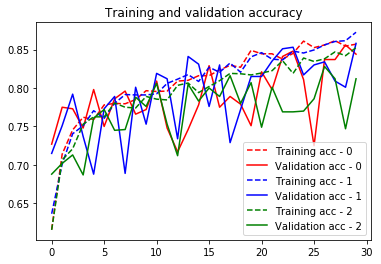

Total Hidden Layers - 2
Found 591 images belonging to 2 classes.
Test Classification Results:
  Pred. VanGogh Correct  - 141
  Pred. Picasso Correct  - 352
  Pred. VanGogh Miss - 25
  Pred. Picasso Miss - 73

Test Accuracy: 0.8341793570219966
VanGogh Accuracy: 0.8493975903614458
Picasso Accuracy: 0.8282352941176471
F1 Score: 0.7421052631578947

Normalized confusion matrix

Total Hidden Layers - 3
Found 591 images belonging to 2 classes.
Test Classification Results:
  Pred. VanGogh Correct  - 141
  Pred. Picasso Correct  - 339
  Pred. VanGogh Miss - 25
  Pred. Picasso Miss - 86

Test Accuracy: 0.8121827411167513
VanGogh Accuracy: 0.8493975903614458
Picasso Accuracy: 0.7976470588235294
F1 Score: 0.717557251908397

Normalized confusion matrix

Total Hidden Layers - 4
Found 591 images belonging to 2 classes.
Test Classification Results:
  Pred. VanGogh Correct  - 116
  Pred. Picasso Correct  - 379
  Pred. VanGogh Miss - 50
  Pred. Picasso Miss - 46

Test Accuracy: 0.8375634517766497
VanGog

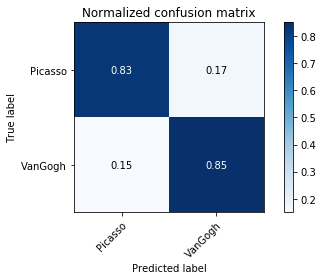

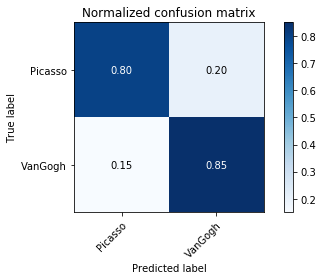

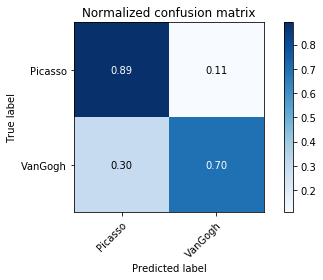

In [18]:
# Plot training history from different LR conditions
def plot_HL_acc(history_list,HL_vals):
    
    for i, training_history in enumerate(history_list):
        acc = training_history.history['acc']
        val_acc = training_history.history['val_acc']
        loss = training_history.history['loss']
        val_loss = training_history.history['val_loss']

        epochs = range(len(acc))
        colors = ['r','b','g']
        
        plt.plot(epochs, acc, colors[i] + '--', label='Training acc - ' + str(n_layers[i]))
        plt.plot(epochs, val_acc, colors[i], label='Validation acc - ' + str(n_layers[i]))
        plt.title('Training and validation accuracy')
        plt.legend()

    plt.show()
    
# Calculate model performance on test dataset
def perf_HL_eval(model_list):
    for i, model_HL in enumerate(model_list):
        print('Total Hidden Layers - ' + str(n_layers[i] + 2)) # we preserve the first two hidden layers
        perf_eval(test_dir, model_HL)
        print()

plot_HL_acc(history_results, n_layers) 
perf_HL_eval(model_results)

___

Looking at the training curves, it seems like the model with 1 additional layer (blue lines - same as the original model) is able to train the best over the 30 epochs. 

But then looking at the classification results tells a slightly different story. The model with nearly the highest test accuracy and best F1 score is our first model (83% and 0.74). This model is also the most balanced with minimal bias in predicting Picasso vs VanGogh in the test set.

The 3rd model with the most layers has slightly higher test accuracy than the others, but has a bias towards classifying Picasso over VanGogh...
___


An important consideration when designing experiments for developing and tuning the model parameters is the initial weights that are randomly initialized each time we train our model. Depending on how the weights are initialized, you will see the model train and perform differently. When trying to evaluate how different parameters influence model training (such as learning rate, or number/size of hidden layers, etc) the best experiment would use a single initialization seed for the weights so that they are random, but held constant for the different hyperparameter conditions.

An even better experiment would use several random initialization seeds to run for each condition so we not only get a comparable measure of performance for the given conditions, but can also determine the sensitivity of the conditions to the intitialized weights. 

Using multiple cores with the keras image generators can impact reproducibility, so this could also be set to only use a single worker to improve consistency.

## While the results above demonstrates a basic deep CNN that can perform pretty well in classifying the artist of provided paintings

## Though I am still wondering how much better a pre-trained CNN might perform - How about ResNet50?

In [19]:
# Lets load ResNet50 from keras and create a base model with pre-trained weights from the ImageNet dataset

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

base_model = ResNet50(weights='imagenet',
                    include_top=False, # We remove the classification layers since we want to replace with our own
                    input_shape=(150,150,3))

base_model.summary()


/home/arthur/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

We want to freeze the feature extraction layers from ResNet50, but will run in to trouble if we also freeze the batch norm layers...

So we need to cycle through and selectively make the batch norm layers trainable

In [20]:
# go through the base model (ResNet50) layers
for layer in base_model.layers:
    layer.trainable = False
    if isinstance(layer, keras.layers.normalization.BatchNormalization): # make sure the batch_norm layers in ResNet are still trainable
        layer.trainable = True
        
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [21]:
# Want to use the base model and add a fully connected layer as well as a sigmoid 
# activation layer for our artist classification 

# base_model.trainable=False

modelRN50t = models.Sequential()
modelRN50t.add(base_model)
modelRN50t.add(layers.Flatten())
modelRN50t.add(layers.Dense(64, activation='relu'))
modelRN50t.add(layers.Dense(1, activation='sigmoid'))

modelRN50t.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

modelRN50t.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                3276864   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 26,864,641
Trainable params: 3,330,049
Non-trainable params: 23,534,592
_________________________________________________________________


In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, # this will rotate the image within a range of 40deg
    width_shift_range=0.2, # the next two will stretch/compress the images
    height_shift_range=0.2,
    shear_range=0.2, # will shear the image
    zoom_range=0.2, # zoom in on image
    horizontal_flip=True,) # can flip the image along the horizontal axis

# Validation set remains the same
val_datagen = ImageDataGenerator(rescale=1./255) 

train_dir = artist_dir + 'train_data/'
val_dir = artist_dir + 'val_data/'

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [23]:
historyRN = modelRN50t.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=val_generator,
      validation_steps=50,
      workers=12) # also added workers to reduce up CPU bottlene

Epoch 1/30
100/100 [==============================] - 19s 188ms/step - loss: 0.5424 - acc: 0.7575 - val_loss: 0.4492 - val_acc: 0.7960
Epoch 2/30
100/100 [==============================] - 11s 114ms/step - loss: 0.3704 - acc: 0.8465 - val_loss: 0.4370 - val_acc: 0.8010
Epoch 3/30
100/100 [==============================] - 12s 116ms/step - loss: 0.3129 - acc: 0.8665 - val_loss: 0.5641 - val_acc: 0.7750
Epoch 4/30
100/100 [==============================] - 11s 114ms/step - loss: 0.2681 - acc: 0.8980 - val_loss: 0.4048 - val_acc: 0.8390
Epoch 5/30
100/100 [==============================] - 11s 114ms/step - loss: 0.2764 - acc: 0.8880 - val_loss: 0.3430 - val_acc: 0.8560
Epoch 6/30
100/100 [==============================] - 11s 115ms/step - loss: 0.2457 - acc: 0.9080 - val_loss: 0.4395 - val_acc: 0.8210
Epoch 7/30
100/100 [==============================] - 11s 115ms/step - loss: 0.2240 - acc: 0.9055 - val_loss: 0.4529 - val_acc: 0.8240
Epoch 8/30
100/100 [==============================] - 1

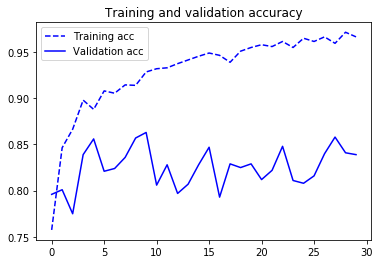

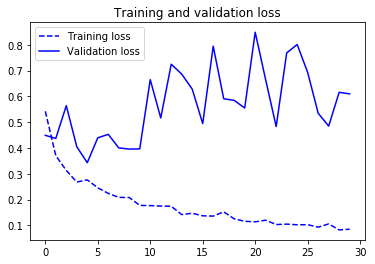

In [24]:
plot_training(historyRN)

Found 591 images belonging to 2 classes.
Test Classification Results:
  Pred. VanGogh Correct  - 129
  Pred. Picasso Correct  - 410
  Pred. VanGogh Miss - 37
  Pred. Picasso Miss - 15

Test Accuracy: 0.9120135363790186
VanGogh Accuracy: 0.7771084337349398
Picasso Accuracy: 0.9647058823529412
F1 Score: 0.832258064516129

Normalized confusion matrix


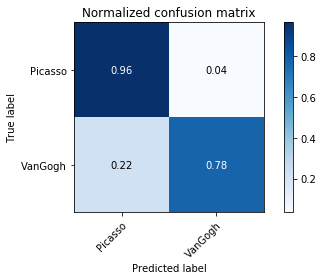

In [25]:
perf_eval(test_dir, modelRN50t)

In [26]:
# Save Model
temp_model.save('Artists_RN50t.h5')


## >90% Test Accuracy w/ Pre-Trained ResNet50 CNN 

Awesome - we can do even better by fine-tuning the classification layers of a pre-trained ResNet50 CNN. Looking at the training curves, there is still room for improvement though! In the future, I would add some dropout before the classification layers to regularize and would also try unfreezing some of the ResNet layers to allow the convolutional layers to better extract the features relevant to our paintings. 